# Overfitting and validation

In this exercise you will explore the overfitting phenomenon and how it can be tackled by using regularization. You will use validation and cross-validation to tune the hyperparameters of the model and to assess its performance.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, interactive
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns


Create the dataset: in this case, we know the true function that we want to learn and generate samples from it. Then, we corrupt the outputs with noise.

In [2]:
def true_function(x):
    return 0.0002*x**5 -0.0111*x**4 -0.1282*x**3 -0.2507*x**2 +0.4657*x + 5.2726 + np.sin(2*x) #define a function
    
def create_data(x, N, SNR):

    f = true_function(x) # noiseless output
    
    std_noise = np.sqrt(np.var(f)/SNR)
    
    y = f + std_noise*np.random.randn(N,1) # add noise on observed data y
    
    data = np.zeros((N, 3)) # initialize dataset
    
    return y, f 

Generate and plot data

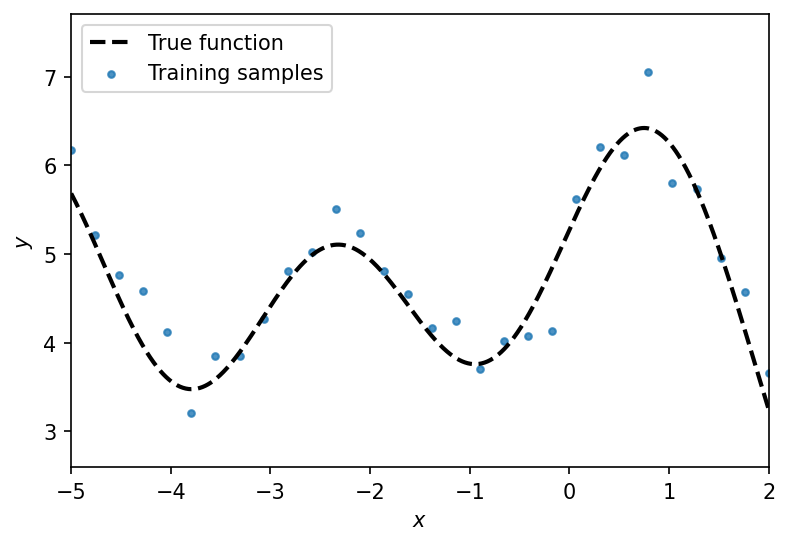

In [3]:
np.random.seed(0) # set random seed
SNR = 10 # signal to noise ratio
N = 30 # number of train data


x_train = np.array(np.linspace(-5, 2, N))[:, np.newaxis] #generate train input
y_train, f_train = create_data(x_train, N, SNR) # create train data N = 30 samples, 10 = variance noise
 

Nt = 1000 # number of test data
x_test = np.array(np.linspace(-5, 2, Nt))[:, np.newaxis] #generate test input
y_test, f_test = create_data(x_test, Nt, SNR) # create test data Nt = 20
 

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_test, f_test, 'k--', alpha=1, label='True function', linewidth = 2)
plt.scatter(x_train, y_train, label='Training samples', color='C0', s=10, alpha=0.8)
#plt.scatter(x_test, y_test, label='Test samples', color='C8', s=10, alpha=0.2)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(np.abs(np.min(f_test))*0.8*np.sign(np.min(f_test)), np.max(f_test)*1.2); 
plt.xlim(np.min(x_test), np.max(x_test)); 
plt.legend(frameon=True, loc = 'best');


### Train model

We now create a prediction model. Since data come from a nonlinear function, a simple method for creating a nonlinear model is that of using polynomial features, generated from the initial features. 

But what is the degree of the polynomial that best approximates the true functions?

In [4]:
def make_features(data_set, degrees): # create polynomial features from data
    data_dict = {}
    for d in degrees: # each element of the dictionary contains a data matrix X with d polynomial features 
        data_dict[d] = PolynomialFeatures(d).fit_transform(data_set) # create polyonmial features of degree d
    return data_dict

In [5]:
scaler = StandardScaler() # use to standardize the data
degrees = range(25) # degrees from 0 to N-1=19

train_dict = make_features(x_train, degrees) # create features for train
test_dict = make_features(x_test, degrees) # create features for test

In [6]:
print('First examples of data matrix of degree 2:\n', train_dict[2][0:4],'\n')
print('First examples of data matrix of degree 3:\n', train_dict[3][0:4])

First examples of data matrix of degree 2:
 [[ 1.         -5.         25.        ]
 [ 1.         -4.75862069 22.64447087]
 [ 1.         -4.51724138 20.40546968]
 [ 1.         -4.27586207 18.28299643]] 

First examples of data matrix of degree 3:
 [[   1.           -5.           25.         -125.        ]
 [   1.           -4.75862069   22.64447087 -107.75644758]
 [   1.           -4.51724138   20.40546968  -92.176432  ]
 [   1.           -4.27586207   18.28299643  -78.17557095]]


In [7]:
error_train = np.empty(len(degrees)) # initialize array error, one for each polynomial degree

for d in degrees:
    X_train = train_dict[d] # select d feeatures
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression() # define linear regression model
    model.fit(X_train_scaled, y_train) # fit linear regression model
    y_hat_train = model.predict(X_train_scaled) # predict
    error_train[d] = mean_squared_error(y_train, y_hat_train) # compute mean squared error
    
bestd = np.argmin(error_train) # find order that gives lowes train error

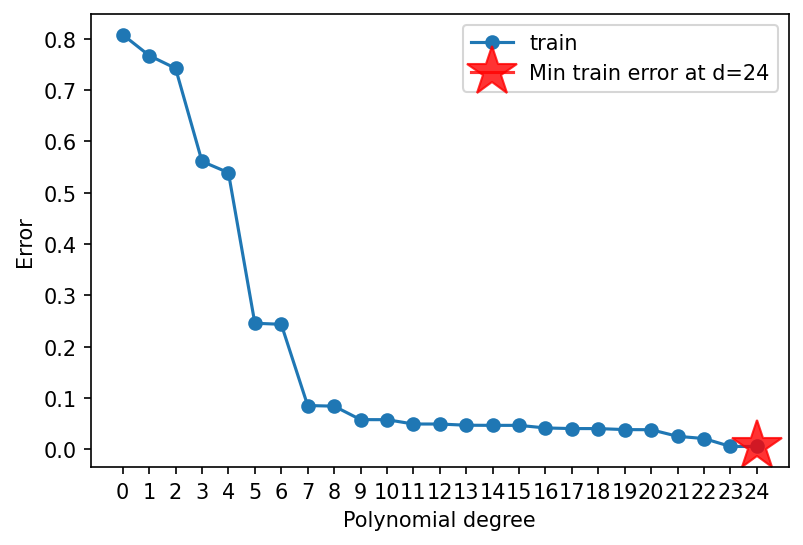

In [8]:
fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, error_train, marker='o', label='train')
plt.plot(bestd, error_train[bestd], marker='*', markersize=25, color='r', label="Min train error at d=%d"%bestd, alpha=0.8)
plt.ylabel('Error')
plt.xlabel('Polynomial degree')
plt.legend(loc='best', frameon=True)
plt.xticks(degrees);

The best model corresponds to degree 24 (max degree between those tested)

### Prediction on test data

Since the model performs very well on train data, what can we expect on test data?

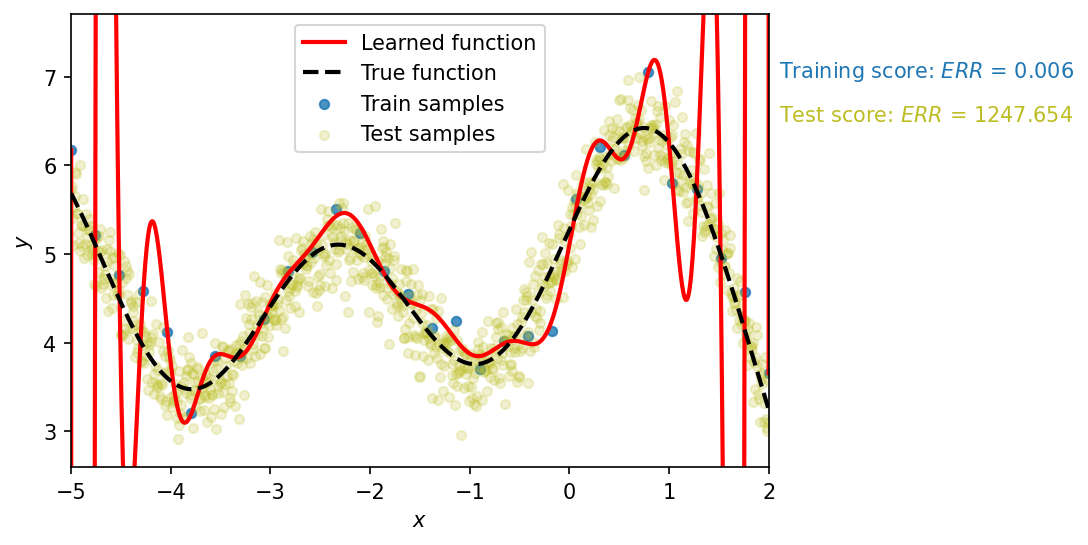

In [9]:
degree = bestd # fix best polynomial order found on the training set


X_train = train_dict[degree] # create train data matrix
X_train_scaled = scaler.fit_transform(X_train) # scale
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model


X_test = test_dict[degree] # create test data matrix
X_test_scaled = scaler.transform(X_test) # scale with information obtained from train data


fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_test, model.predict(X_test_scaled), linestyle='-', label='Learned function', color='r', linewidth=2)
plt.scatter(x_train, y_train, alpha=0.8, label='Train samples', color='C0', s=20)
plt.scatter(x_test, y_test, alpha=0.2, label='Test samples', color='C8', s=20)
plt.plot(x_test, f_test, 'k--',alpha=1, label='True function', linewidth=2)
plt.ylim(np.abs(np.min(f_test))*0.8*np.sign(np.min(f_test)), np.max(f_test)*1.2)
plt.xlim(np.min(x_test), np.max(x_test))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.text(2.1, 7, "Training score: $ERR$ = {0:.3f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
         color='C0')
plt.text(2.1, 6.5,"Test score: $ERR$ = {0:.3f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
plt.legend(loc='best', frameon=True);

The test error is huge compared to the train error. We overfitted the train data with a model that is too complex. Let's analyze how the erros very with the model order.

In [10]:
r = (1, max(degrees))

def plot_poly(degree = 1):
    
    X_train = train_dict[degree] # select d feeatures
    X_train_scaled = scaler.fit_transform(X_train)
    model = LinearRegression() # define linear regression model
    model.fit(X_train_scaled, y_train) # fit linear regression model

    
    X_test = test_dict[degree] # select d feeatures
    X_test_scaled = scaler.transform(X_test)
    
    y_hat_test = model.predict(X_test_scaled)
          
    fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot(x_test, y_hat_test, linestyle='-', label="Learned function", linewidth=2, color='C3')
    plt.plot(x_test, f_test, 'k--',alpha=1, label="True function", linewidth=2)
    plt.scatter(x_train, y_train, alpha=0.8, label="Train samples", color='C0', s=20)
    plt.scatter(x_test, y_test, alpha=0.2, label="Test samples", color='C8', s=20)
    plt.xlabel("$x$"); plt.ylabel("$y$")
    plt.ylim(np.min(f_test)*0.9, np.max(f_test)*1.1);  
    plt.xlim(np.min(x_test), np.max(x_test))
    plt.legend(loc='best', frameon=True)
    plt.text(2.1, 7, "Training score: $ERR$ = {0:.2f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
         color='C0')
    plt.text(2.1, 6.5,"Test score: $ERR$ = {0:.2f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
    plt.show()
    
w = interactive(plot_poly, degree=r)
w

interactive(children=(IntSlider(value=1, description='degree', max=24, min=1), Output()), _dom_classes=('widge…

Observations from the interactive chart:

- Low order models (orders 1 and 2) are not able to accurately approximate the shape of the true model from which the data was generated. It is observed that the train error and the test error have similar values, and both are relatively high. We say that these models suffer from **high bias** or even **underfitting**



- As the order rises, it is observed that the trained models have increasingly complex shapes. These models, in addition to learning the shape of the real function, also tend to learn the noise contained in the specific training set on which they are trained. It is noted that train error and test error appear to be **very different**, in particular the train error tends to decrease as the order of the model increases. On the contrary, the test error tends to increase very strongly as the order of the model increases. These models are said to suffer from **high variance** or even **overfitting**

Compute new the test errors for a high variance and a high bias model

#### High variance

In [11]:
X_train = train_dict[max(degrees)] # select d feeatures
X_train_scaled = scaler.fit_transform(X_train)
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

X_test = test_dict[max(degrees)] # select d feeatures
X_test_scaled = scaler.transform(X_test)

test_error_hv = mean_squared_error(y_test, model.predict(X_test_scaled))
test_error_hv

1247.6543175625484

#### High bias

In [12]:
X_train = train_dict[1] # select d feeatures
X_train_scaled = scaler.fit_transform(X_train)
model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model

X_test = test_dict[1] # select d feeat
X_test_scaled = scaler.transform(X_test)

test_error_hb = mean_squared_error(y_test, model.predict(X_test_scaled))
test_error_hb

0.7281439095720389

### Learning curves

A useful method to evaluate the performance of a model in terms of bias / variance is to plot the learning curves. They illustrate the learning process as the number of samples of the training set varies.

When a dataset is small, it is easy for a complex model to do it with precision but risking overfitting. As the dataset grows, it is reasonable to expect the train error to increase. On the contrary, with a small dataset it is easy for the model trained on it to not generalize well on new data and consequently the test error will be high. As the dataset grows, it is expected that the model will generalize better and therefore the test error will decrease.

They also provide us with very useful empirical indications on the number of train data that we should use to train the model set an order by keeping underfitting and overfitting under control.

In [13]:
def plot_learning_curves(X, y):
    np.random.seed(0) # set seed
    X_train_curv, X_test_curv, y_train_curv, y_test_curv = train_test_split(X, y, test_size=0.2)
    train_errors, test_errors = [], [] # init errors
    
    scaler = StandardScaler()
    X_train_curv_scaled = scaler.fit_transform(X_train_curv)
    X_test_curv_scaled = scaler.transform(X_test_curv)    
    model = LinearRegression()
    N_curv = len(X_train_curv_scaled)
    
    for m in range(1, N_curv): # consider different sizes of training data
        model.fit(X_train_curv_scaled[:m], y_train_curv[:m]) # fit linear regressions
        y_train_predict = model.predict(X_train_curv_scaled[:m]) # predict on train
        y_test_predict = model.predict(X_test_curv_scaled) # predict on validation set
        train_errors.append(mean_squared_error(y_train_predict, y_train_curv[:m])) # compute train error
        test_errors.append(mean_squared_error(y_test_predict, y_test_curv)) # compute test error
        
    fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
    plt.plot((train_errors), "C0", linewidth=3, label = "Train")
    plt.plot((test_errors), "C8", linewidth=3, label = "Test")
    plt.ylim(0, 3); plt.xlim([0, N_curv])
    plt.xlabel('Training set size')
    plt.ylabel('Error')
    plt.legend(frameon=True)
    plt.show()

In [14]:
r_degree = (1, max(degrees)) # slider

def learning_curves(degree=1):
    X_train_curv = train_dict[degree] # select d feeatures
    plot_learning_curves(X_train_curv, y_train) # compute errors and plot curves

w = interactive(learning_curves, degree=r_degree)
w    

interactive(children=(IntSlider(value=1, description='degree', max=24, min=1), Output()), _dom_classes=('widge…

### Validation

A very useful technique to fight ovefitting and underfitting is to use part of the train data for the validation of the model, these data are part of a new dataset that is called **validation dataset**.

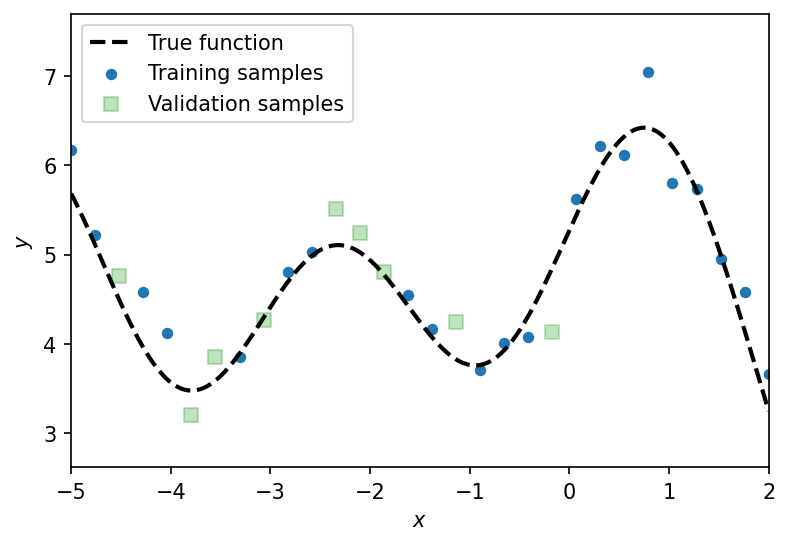

In [15]:
x_train_v, x_val_v, y_train_v, y_val_v = train_test_split(x_train, y_train, test_size=0.3) # create train and validation set


fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_test, f_test, 'k--', alpha=1, label='True function', linewidth=2)
plt.scatter(x_train_v, y_train_v, alpha=1, label='Training samples', color='C0', s=20)
#plt.scatter(x_test, y_test, alpha=0.2, label='Test samples', color='C8', s=20)
plt.scatter(x_val_v, y_val_v, label='Validation samples', color='C2', s=50, marker='s', alpha=0.3)
plt.xlabel('$x$'); plt.ylabel('$y$');
plt.xlim([np.min(x_test,), np.max(x_test,)]); 
plt.ylim([np.min(y_test)*0.9, np.max(y_test)*1.1])
plt.legend(frameon=True);

In [16]:
def make_features2(train_set, val_set, degrees): # create features on two different datasets
    train_dict = {}
    val_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        val_dict[d] = PolynomialFeatures(d).fit_transform(val_set.reshape(-1,1))
    return train_dict, val_dict

In [17]:
train_dict_v, val_dict_v = make_features2(x_train_v, x_val_v, degrees) # create features on train and validation set

In [18]:
error_train = np.empty(len(degrees)) # init error train
error_val = np.empty(len(degrees)) # init error validation

In [19]:
for d in degrees: # for each degree
    X_train_v = train_dict_v[d] # data matrix train
    X_val_v = val_dict_v[d] # data matrix validation
    
    X_train_scaled_v = scaler.fit_transform(X_train_v) # scale train data
    X_val_scaled_v = scaler.transform(X_val_v) # scale validation data
    
    model = LinearRegression() # define linear model
    model.fit(X_train_scaled_v, y_train_v) # fit linear model in train data
    y_train_hat_v = model.predict(X_train_scaled_v) # predict on train
    y_val_hat_v = model.predict(X_val_scaled_v) # predict on test
    error_train[d] = mean_squared_error(y_train_v, y_train_hat_v) # error train
    error_val[d] = mean_squared_error(y_val_v, y_val_hat_v) # error validation
    
bestd = np.argmin(error_val) # find best model on validation set
print('Best model degree: ' + str(bestd))

Best model degree: 13


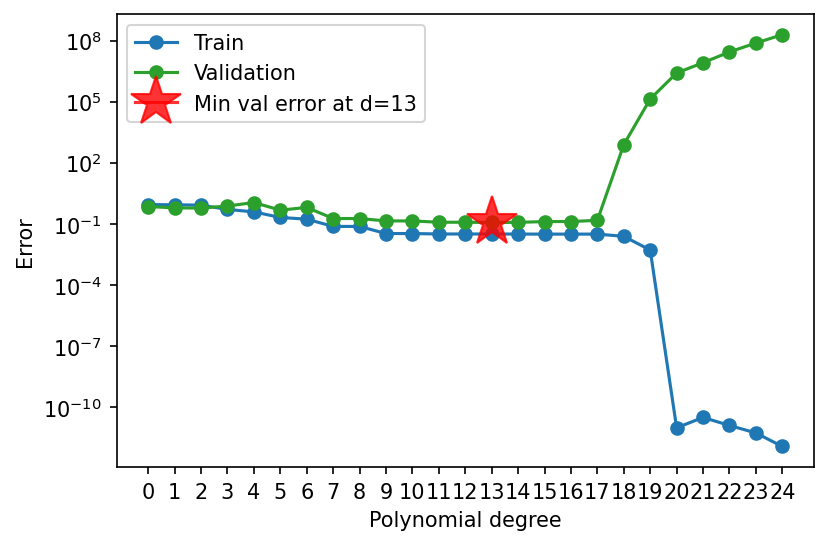

In [20]:
fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, error_train, marker='o', label='Train')
plt.plot(degrees, error_val, marker='o', label='Validation',c='C2')
plt.plot(bestd, error_val[bestd], marker='*',markersize=25, color='r', label="Min val error at d=%d"%bestd, alpha=0.8)
plt.ylabel('Error')
plt.xlabel('Polynomial degree')
plt.legend(loc='best', frameon=True)
plt.yscale("log")
plt.xticks(degrees);

### Prediction with model chosen with validation

Let's refit on the entire training set and assess performance on test set

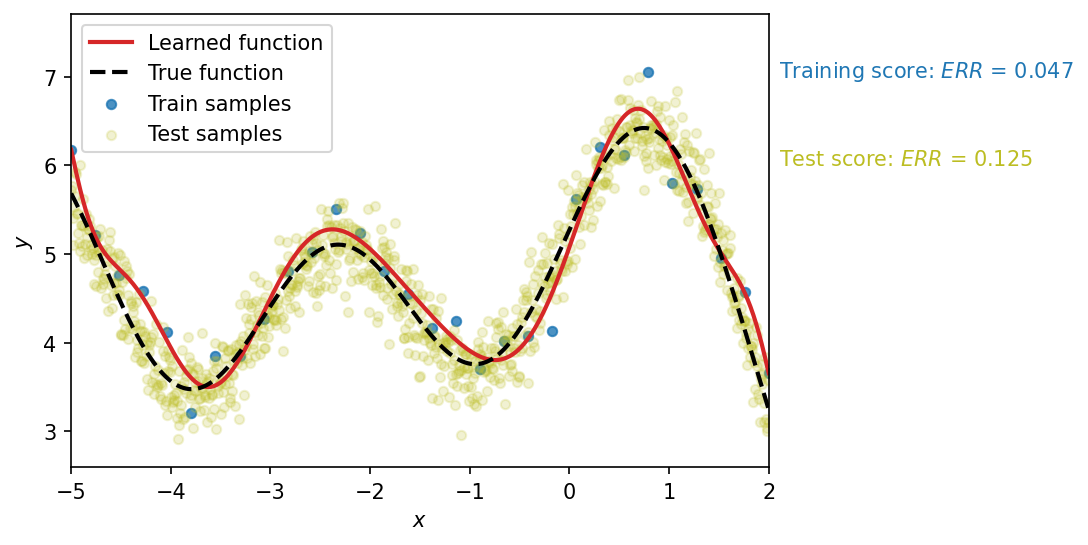

In [21]:
X_train = train_dict[bestd] # data matrix train data
X_train_scaled = scaler.fit_transform(X_train) # scale data

X_test = test_dict[bestd] # data matrix test data
X_test_scaled = scaler.transform(X_test) # scale data

model = LinearRegression() # define linear regression model
model.fit(X_train_scaled, y_train) # fit linear regression model


y_hat_test = model.predict(X_test_scaled)

fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_test, y_hat_test, linestyle='-', label="Learned function", linewidth=2, color='C3')
plt.plot(x_test, f_test, 'k--',alpha=1, label="True function", linewidth=2)
plt.scatter(x_train, y_train, alpha=0.8, label="Train samples", color='C0', s=20)
plt.scatter(x_test, y_test, alpha=0.2, label="Test samples", color='C8', s=20)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.ylim(np.abs(np.min(f_test))*0.8*np.sign(np.min(f_test)), np.max(f_test)*1.2)
plt.xlim(np.min(x_test), np.max(x_test))
plt.legend(loc='best', frameon=True)
plt.text(2.1, 7, "Training score: $ERR$ = {0:.3f}".format(mean_squared_error(y_train, model.predict(X_train_scaled))),
     color='C0')
plt.text(2.1, 6,"Test score: $ERR$ = {0:.3f}".format(mean_squared_error(y_test, model.predict(X_test_scaled))), color='C8')
plt.show()

test_error_val = mean_squared_error(y_test, y_hat_test) # compute test error

High variance model: 1247.6543175625484
High bias model: 0.7281439095720389
Validated model: 0.12524581881039867


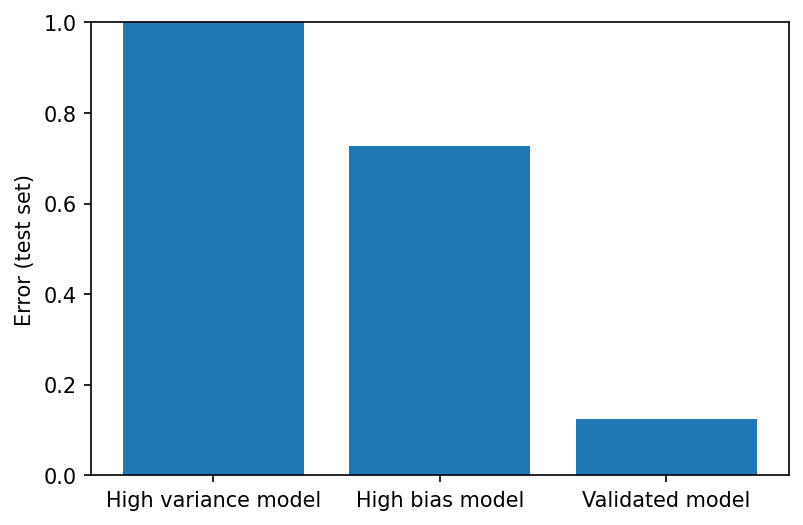

In [22]:
errors = ['High variance model', 'High bias model', 'Validated model'] # labels for the plot

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2, 3],[test_error_hv, test_error_hb, test_error_val], tick_label = errors)
plt.ylabel('Error (test set)');
plt.ylim([0, 1e0]);

print('High variance model:', test_error_hv)
print('High bias model:', test_error_hb)
print('Validated model:', test_error_val)


### Cross-validation

Cross-validation is a technique that can be used in the presence of a good number of the observed sample or training set. In particular the $k$-fold cross-validation consists in the subdivision of the total dataset into $k$ parts of equal number and, at each step, the $k$-th part of the dataset comes to be the validation dataset, while the remaining part constitutes the training dataset. Thus, for each of the $k$ parts (usually $k = 10$) the model is trained, thus avoiding problems of overfitting, but also of asymmetric sampling (and therefore affected by bias) of the training dataset, typically due to the subdivision of the dataset in only two parts (i.e. training and validation dataset).

In other words, the sample is subdivided into groups of equal number, then it is iteratively excluded one group at a time and, on this excluded group, predictions are made using the model trained groups not excluded. This is to verify the goodness of the prediction model used.

In [23]:
n_folds = 5 # 5-fold cross validation ==> N-N/n_folds data for each training set
 
train_errors = np.zeros((len(degrees), n_folds)) # init train errors - for each degree and for each fold
valid_errors = np.zeros((len(degrees), n_folds)) # init validation errors - for each degree and for each fold

Here is the cross-validation code

In [24]:
fold = 0 
for train_idx, valid_idx in KFold(n_folds, shuffle=True).split(range(N)): # for each fold
    train_dict_cv, valid_dict_cv = make_features2(x_train[train_idx], x_train[valid_idx], degrees) # obtain indexes of data in the folds
    
    for d in degrees: # for each degree
        model = LinearRegression() # linear regression model
        X_train = train_dict_cv[d]; # data matrix train
        X_train_scaled = scaler.fit_transform(X_train) # scale train data
        
        X_valid_v = valid_dict_cv[d] # data matrix validation
        X_valid_v_scaled = scaler.transform(X_valid_v) # scale validation data
        
        model.fit(X_train_scaled, y_train[train_idx]) # fit linear model
        train_errors[d, fold] = mean_squared_error(y_train[train_idx], model.predict(X_train_scaled)) # train error
        valid_errors[d, fold] = mean_squared_error(y_train[valid_idx], model.predict(X_valid_v_scaled)) # test error
    fold += 1

Compute mean and standard deviation of the cross-validation errors, both for the train and validation set

In [25]:
mean_train_errors = train_errors.mean(axis=1) # mean of train errors for each degree
mean_valid_errors = valid_errors.mean(axis=1) # mean of validation errors for each degree
std_train_errors = train_errors.std(axis=1) # standard deviation of train errors for each degree 
std_valid_errors = valid_errors.std(axis=1) # standard deviation of validation errors for each degree

Fit mdoel on the order chosen from cross-validation, and compare the test error with previous models

Best model degree: 10


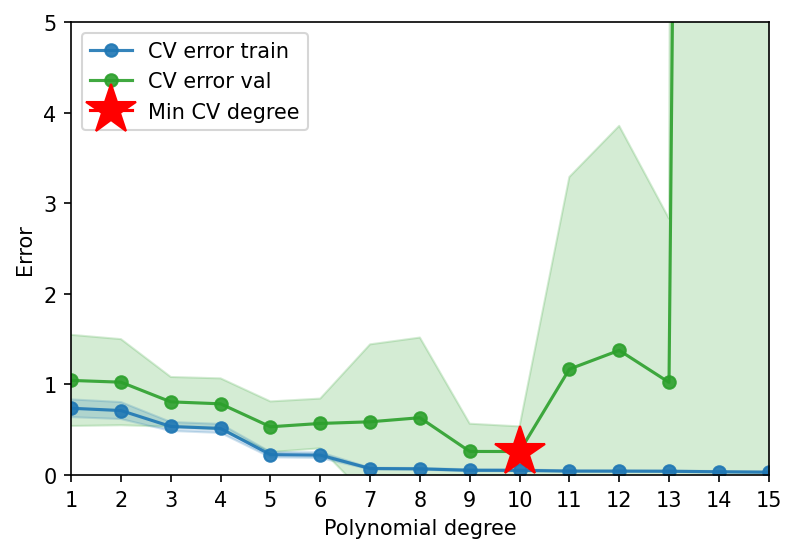

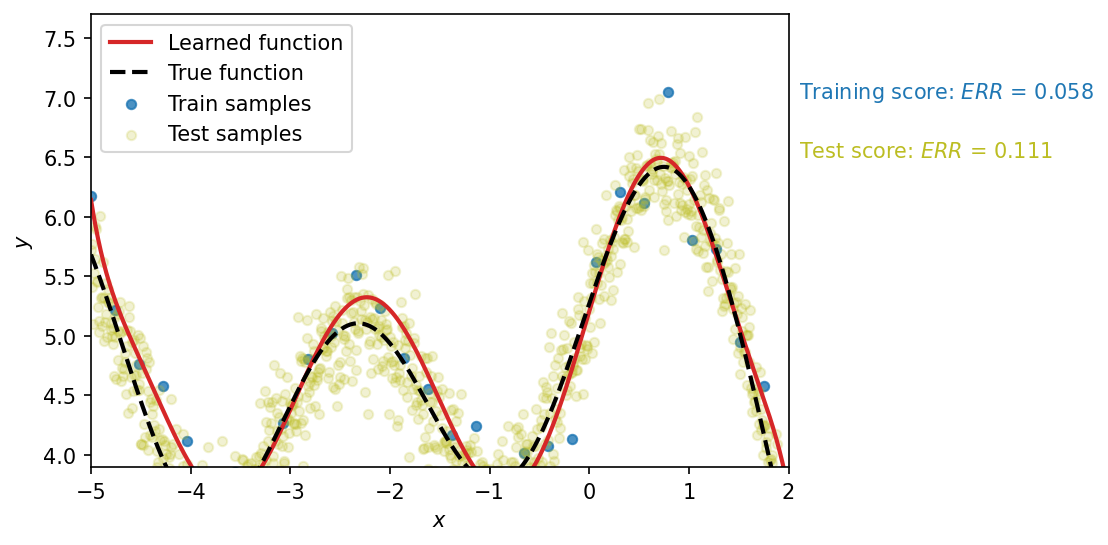

In [26]:
degree_cv = np.argmin(mean_valid_errors) # find degree that gave smallest cross-validation error
print('Best model degree: ' + str(degree_cv))

X_train = train_dict[degree_cv]
X_train_scaled = scaler.fit_transform(X_train)

X_test = test_dict[degree_cv]
X_test_scaled = scaler.transform(X_test)

model = LinearRegression() # define linear model
model.fit(X_train_scaled, y_train) # estimate linear model

y_hat_train = model.predict(X_train_scaled) # predict on test with features compute with best degree found by cv
y_hat_test = model.predict(X_test_scaled) # predict on test with features compute with best degree found by cv

train_error_cv = mean_squared_error(y_train, y_hat_train) # compute test error = mean_squared_error(yhat, y_test) # test error
test_error_cv = mean_squared_error(y_test, y_hat_test) # compute test error = mean_squared_error(y_train, model.predict(X_train)) # train error



fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(degrees, mean_train_errors, marker='o', label='CV error train', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='o', label='CV error val', alpha=0.9, c='C2')

plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color='C2', alpha=0.2)
plt.fill_between(degrees, mean_train_errors-std_train_errors, mean_train_errors+std_train_errors, color='C0', alpha=0.2)


plt.plot(degree_cv, mean_valid_errors[degree_cv], marker='*', markersize=25, label='Min CV degree',color='r')
plt.xticks(np.arange(max(degrees)))
plt.ylabel('Error')
plt.xlabel('Polynomial degree')
plt.legend(loc='best', frameon=True)
plt.xlim([1, 15]); 
plt.ylim([0, 5]);



fig = plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.plot(x_test, y_hat_test, linestyle='-', label="Learned function", linewidth=2, color='C3')
plt.plot(x_test, f_test, 'k--',alpha=1, label="True function", linewidth=2)
plt.scatter(x_train, y_train, alpha=0.8, label="Train samples", color='C0', s=20)
plt.scatter(x_test, y_test, alpha=0.2, label="Test samples", color='C8', s=20)
plt.xlabel("$x$"); plt.ylabel("$y$")
plt.ylim(np.abs(np.min(f_test))*1.2*np.sign(np.min(f_test)), np.max(f_test)*1.2); 
plt.xlim(np.min(x_test), np.max(x_test))
plt.legend(loc='best', frameon=True)
plt.text(2.1, 7, "Training score: $ERR$ = {0:.3f}".format(train_error_cv),
     color='C0')
plt.text(2.1, 6.5,"Test score: $ERR$ = {0:.3f}".format(test_error_cv), color='C8')
plt.show()




High variance model: 1247.6543175625484
High bias model: 0.7281439095720389
Validated model: 0.12524581881039867
Cross-Validated model: 0.11079054446972682


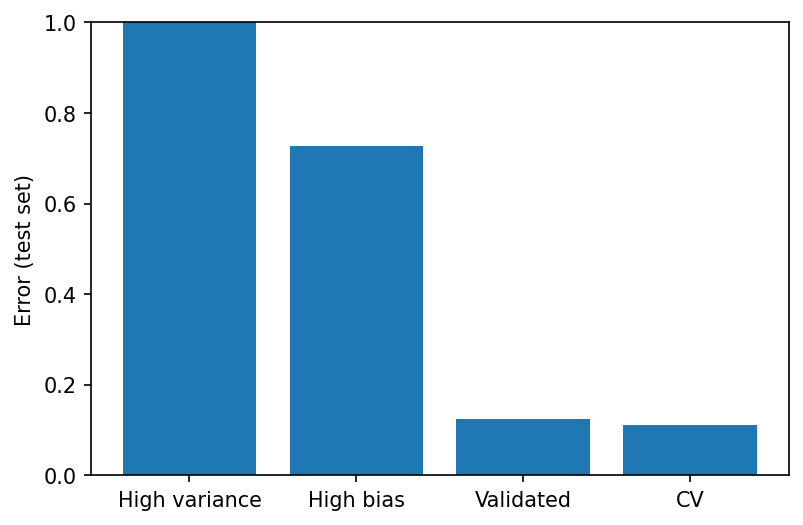

In [27]:
errors = ['High variance', 'High bias', 'Validated', 'CV'] # labels for the plot

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2, 3, 4],[test_error_hv, test_error_hb, test_error_val, test_error_cv], tick_label = errors)
plt.ylabel('Error (test set)');
plt.ylim([0, 1e0]);

print('High variance model:', test_error_hv)
print('High bias model:', test_error_hb)
print('Validated model:', test_error_val)
print('Cross-Validated model:', test_error_cv)

### Regularization

Let's see how different regulariation strengths, on a high order model, can lead us to a better model and better predictions

In [28]:
r_alpha = (-10, 5) # regularization slider
def regularization(alpha=-10):
    alpha = 10**alpha # set regularization on a log scale

    fig, col = plt.subplots(1, 2, figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')

    X_train = train_dict[max(degrees)] # dataset train
    X_train_scaled = scaler.fit_transform(X_train) 
    
    X_test = test_dict[max(degrees)] # dataset test
    X_test_scaled = scaler.transform(X_test)
    
    ridge = Ridge(alpha=alpha) # Ridge regression model
    ridge.fit(X_train_scaled, y_train) # fit ridge model
    
    y_hat_train = ridge.predict(X_train_scaled)
    y_hat_test = ridge.predict(X_test_scaled)
    
    col[0].plot(x_test, f_test, 'k--',alpha=1, label='True function', linewidth=2)
    col[0].scatter(x_train, y_train, label="Training", alpha=0.6, color='C0', s=20)
    col[0].scatter(x_test, y_test, label="Testing", alpha=0.2, color='C8', s=20) 
    col[0].plot(x_test, y_hat_test, '-', label="$\lambda$ = %s" % str(alpha), color='C3', linewidth=2)    
    col[0].text(-4, 7, "Training score: $ERR$ = {0:.3f}".format(mean_squared_error(y_train, y_hat_train)),
         color='C0')
    col[0].text(-4, 6.5, "Test score: $ERR$ = {0:.3f}".format(mean_squared_error(y_test, y_hat_test)), 
                color='C1')
    col[0].set_ylabel('y'); col[0].set_xlabel('x');  col[0].legend(loc='lower right')
    col[0].set_ylim(np.min(y_test)*0.9, np.max(y_test)*1.1); 
    col[0].set_xlim((np.min(x_test), np.max(x_test)))
    
    coef = ridge.coef_.ravel()
    col[1].semilogy(np.abs(coef), marker='o', label="$\lambda$ = %s" % str(alpha))
    col[1].set_ylim([1e-5, 1e5]);  col[1].set_xlim([1, d])
    col[1].set_ylabel('abs(coefficient)'); col[1].set_xlabel('coefficients')
    col[1].legend(loc='upper left')
    col[1].set_xticks=(np.arange(d));
    
    
    plt.tight_layout()
    plt.show()
w = interactive(regularization, alpha=r_alpha)
w

interactive(children=(IntSlider(value=-10, description='alpha', max=5, min=-10), Output()), _dom_classes=('wid…

#### Choice of the hyperparameter $\lambda$ via cross-validation

The following code performs a grid search usign cross-validation to find the best regularization parameter. Then, a model is fit with the chosen hyperparameter, and its performance is tested on the test set

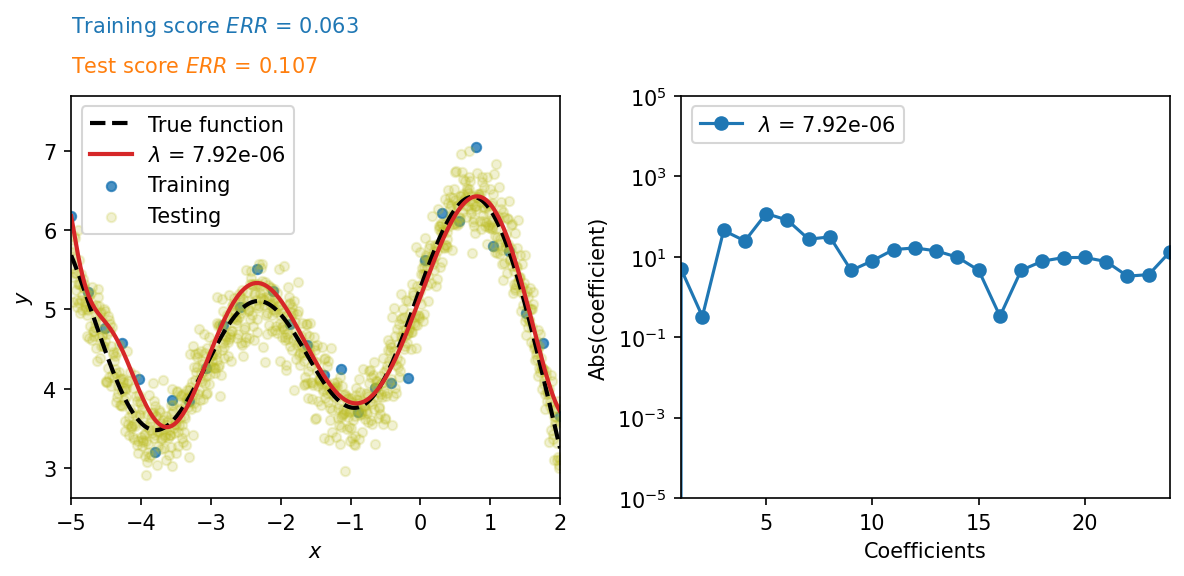

In [29]:
fixed_degree = max(degrees) 
param_grid = np.logspace(-6, -5, 100)

X_train = train_dict[fixed_degree] # dataset train
X_train_scaled = scaler.fit_transform(X_train) 

X_test = test_dict[fixed_degree] # dataset test
X_test_scaled = scaler.transform(X_test)

ridge = RidgeCV(alphas=param_grid)
ridge.fit(X_train_scaled, y_train)
alpha = ridge.alpha_

y_hat_test_reg = ridge.predict(X_test_scaled)

fig, col = plt.subplots(1, 2, figsize=(8, 4), dpi= 150, facecolor='w', edgecolor='k')
test_error_reg = mean_squared_error(y_test, y_hat_test_reg)
                                    
col[0].plot(x_test, f_test, 'k--', alpha=1, label='True function', linewidth=2)
col[0].scatter(x_train, y_train, label="Training", s=20, alpha=0.8, color = 'C0')
col[0].scatter(x_test, y_test, label="Testing", color='C8', s=20, alpha=0.2 )
 
col[0].plot(x_test, y_hat_test_reg,'-', label="$\lambda$ = {:.2e}".format(alpha), color='C3', linewidth=2)
col[0].text(-5, 8.5, "Training score $ERR$ = {0:.3f}".format(mean_squared_error(y_train, ridge.predict(X_train_scaled))),
     color='C0')
col[0].text(-5, 8, "Test score $ERR$ = {0:.3f}".format(mean_squared_error(y_test, ridge.predict(X_test_scaled))), 
            color='C1')
col[0].set_ylabel('$y$'); col[0].set_xlabel('$x$')
col[0].legend(loc='upper left')
col[0].set_ylim([np.min(y_test)*0.9, np.max(y_test)*1.1]); 
col[0].set_xlim([np.min(x_test), np.max(x_test)])
coef = ridge.coef_.ravel()


col[1].semilogy(np.abs(coef), marker='o', label="$\lambda$ = {:.2e}".format(alpha))
col[1].set_ylim([1e-5, 1e5]); 
col[1].set_xlim([1, fixed_degree])
col[1].set_ylabel('Abs(coefficient)'); 
col[1].set_xlabel('Coefficients')
col[1].legend(loc='upper left')
col[1].set_xticks=(degrees)
plt.tight_layout()
plt.show()

Compare the errors of this last model with the previous ones

High variance model: 1247.6543
High bias model: 0.7281
Validated model: 0.1252
Cross-validated model: 0.1108
Regularized model: 0.1067


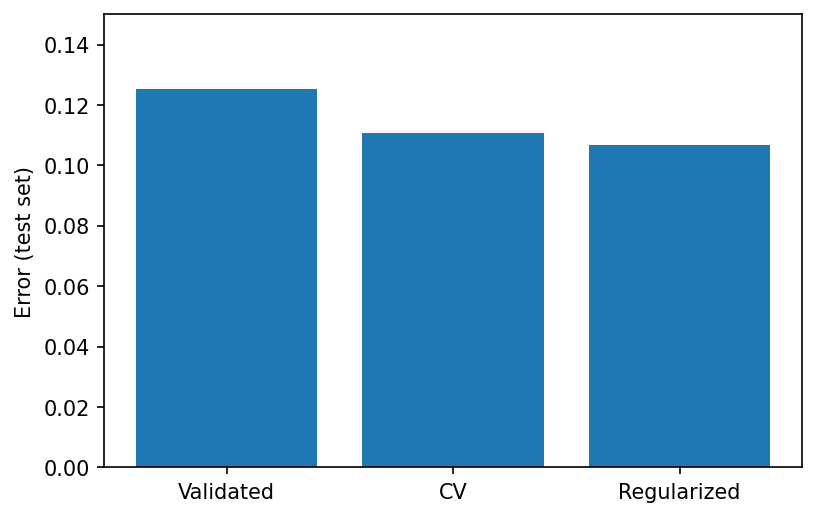

In [30]:
errors = ['Validated', 'CV', 'Regularized'] # labels for the plot

fig=plt.figure(figsize=(6, 4), dpi= 150, facecolor='w', edgecolor='k')
plt.bar([1, 2, 3 ],[ test_error_val, test_error_cv, test_error_reg], tick_label = errors)
plt.ylabel('Error (test set)');
plt.ylim([0, 1.5e-1]);

print("High variance model: {0:.4f}".format(test_error_hv))
print("High bias model: {0:.4f}".format(test_error_hb))
print("Validated model: {0:.4f}".format(test_error_val))
print("Cross-validated model: {0:.4f}".format(test_error_cv))
print("Regularized model: {0:.4f}".format(test_error_reg))